# Effect of Forcings on CAMELs Simulations

Now we can look at the output and see which forcing variables have the most error for each basin. 
This code will make one figure per basin, such that you can look at the forcing error effects in each basin separately. 
In the notebook `camels_pysumma.ipynb` you decided if you wanted to run, in order of increasing complexity: 
 - 1)   `default_prob = 1`: the "default" configuration with the "default" parameters. By "default" we mean whatever you chose in the summa setup files. 
 - 2a) `lhs_prob = 1`: the default configuration with exploration of the parameter space.
 - 2b) `config_prob = 1`: the default parameters with 8 different configurations (choices that have been seen to affect the model output in previous research) 
 - 3)   `lhs_config_prob = 1`: 8 different configurations with exploration of the parameter space.


<br>

### Make problem complexity choices here:
In this notebook, you can only choose one choice as 1. We suggest you choose the most complex problem you ran. 
DO NOT choose one of these to be one here if you did not choose it to be one before.

In [1]:
# This will only let one variable equal 1
default_prob = 1
lhs_prob = 1
config_prob = 0
lhs_config_prob = 0
if lhs_config_prob==1:
    default_prob = 0
    lhs_prob = 0
    config_prob = 0
elif config_prob==1:
    default_prob = 0
    lhs_prob = 0
elif lhs_prob==1:
    default_prob = 0

Load the imports.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.gridspec as gridspec

<br>

### You will need to edit these paths to be your folders

In [3]:
# Some folder places
home = '/glade/work/ashleyvb/CAMELs'

<br>
Keep these the same.

In [4]:
top_folder = home+'/summa_camels'
settings_folder = top_folder+'/settings.v1'
regress_folder = home+'/regress_data'

<br>

# Summary Statistics of Error on Output
First we need to calculate KGEs on the data, and then we summarize the results by problem complexity level.
KGE means perfect agreement if it is 1, and <0 means the mean is a better guess. 
All data have a small number added so we don't divide by 0. 
At the start, we must do some bookkeeping of divide the decision set into each problem complexity (if we ran a bigger problem containing more than one set). 

In [5]:
# Get names for each set of problem complexities.
if lhs_config_prob==1: 
    suffix = '_configs_latin.nc'
    default_name = '++BallBerry++lightSnow++logBelowCanopy++0'
    lat_name = [default_name[:-1]+str(i) for i in range(0,11)]
elif lhs_prob==1:
    suffix = '_latin.nc'
    default_name = '0'  
    lat_name = [str(i) for i in range(0,11)]
elif config_prob==1:
    suffix = '_configs.nc'
    default_name = '++BallBerry++lightSnow++logBelowCanopy++'  
    lat_name = default_name
elif default_prob==1:
    suffix = '_hru.nc'
    default_name = 'default'
    lat_name = default_name
sim_truth = xr.open_dataset(top_folder+'/output/merged_day/NLDAStruth'+suffix)

In [6]:
# Get decision names off the files
if config_prob==1 or lhs_prob==1 or lhs_config_prob==1: decision_set = np.array(sim_truth['decision']) 
else: decision_set = np.array(['default'])

In [7]:
# Get only configuration and default param decision names, and only latin params and default configuration decision names
ndec = len(decision_set)
if config_prob==0: cfg_name = decision_set[range(0,ndec,11)]
else: cfg_name = decision_set
if lhs_config_prob==1: cfglat_name = [c[:-1]+str(i) for i in range(1,11) for c in cfg_name]
elif lhs_prob==1: cfglat_name = lat_name
elif config_prob==1: cfglat_name = cfg_name
elif default_prob==1: cfglat_name = default_name

<br>
Next we get the forcing and output names, and find the HRUs and their locations. 

In [8]:
# Set forcings and create dictionaries
constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
forc_sim = constant_vars #we simulated these as output too
comp_sim=['scalarSurfaceRunoff','scalarAquiferBaseflow','scalarInfiltration','scalarRainPlusMelt','scalarSoilDrainage',
          'scalarLatHeatTotal','scalarSenHeatTotal','scalarSnowSublimation',
          'scalarSWE',
          'scalarCanopyWat',
          'scalarNetRadiation','scalarTotalET','scalarTotalRunoff','scalarTotalSoilWat']
var_sim = np.concatenate([forc_sim, comp_sim])

In [9]:
# Get number of HRUs and small add
attrib = xr.open_dataset(top_folder+'/settings.v1/attributes.nc')
the_hru = np.array(attrib['hruId'])
small_add = 1e-10 # so no zeros in KGE

In [10]:
#get lat long for plotting purposes later on
df =  pd.read_csv(regress_folder+'/camels_topo.txt',delimiter=';')
df['hru'] = range(0,671)
xr_tmp = df.set_index(['hru']).to_xarray()
xr_tmp = xr_tmp.assign_coords(hru=xr_tmp['gauge_id'])
xr_tmp = xr_tmp.sel(hru=the_hru)
lr_attrib = xr_tmp

<br>
Now run the actual computations on KGE. 
This can take some time. 
It takes about 1/20th of the time it took to run the whole problem, so if you ran the most complex problem with `lhs_config_prob`=1 and it took 584 minutes to complete (9 hrs, 44 min), it will take ~30 minutes to run this. 

In [11]:
# definitions for KGE computation
def covariance(x,y,dims=None):
    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)

def correlation(x,y,dims=None):
    return (covariance(x,y,dims)) / (x.std(dims) * y.std(dims))

In [12]:
# set up xarray
hrud = sim_truth['hru'] #indices here are 0 to number of basins
shape = ( len(decision_set),len(hrud), len(forc_sim))
dims = ('decision','hru','var')
coords = {'decision':decision_set,'hru': hrud, 'var':forc_sim}
error_data = xr.Dataset(coords=coords)
for s in comp_sim:
    error_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [13]:
%%time
truth0_0 = sim_truth.drop_vars('hruId').load()
for v in forc_sim:
    truth = truth0_0
    truth = truth.isel(time = slice(365*24,(365*6+2)*24))+small_add #don't include first year, 5 years
    sim = xr.open_dataset(top_folder+'/output/merged_day/NLDASconstant_' + v + suffix)
    sim = sim.drop_vars('hruId').load()
    sim = sim.isel(time = slice(365*24,(365*6+2)*24))+small_add #don't include first year, 5 years
    r = sim.mean(dim='time') #to set up xarray since xr.dot not supported on dataset and have to do loop
    for s in var_sim:         
        r[s] = correlation(sim[s],truth[s],dims='time')
    ds = 1 - np.sqrt( np.square(r-1) 
        + np.square( sim.std(dim='time')/truth.std(dim='time') - 1) 
        + np.square( sim.mean(dim='time')/truth.mean(dim='time') - 1) )
    ds0 = ds.load()
    for s in comp_sim:
        error_data[s].loc[:,:,v]  = ds0[s]
    print(v)

airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 1min 47s, sys: 27.9 s, total: 2min 15s
Wall time: 2min 17s


In [14]:
# if you want to save it
#error_data.to_netcdf(home+'/regress_data/error_data.nc') 
#error_data = xr.open_dataset(home+'/regress_data/error_data.nc') 

<br>

Summarize this by totals over all output variables and each output variable, and ranks each constant forcing from most error to least error.

In [15]:
# setup summaries by simulated output variable
summ_kind = ['total','rank']
shape = (len(decision_set),len(hrud),len(forc_sim),len(summ_kind))
dims = ('decision','hru','var','summary')
coords = {'decision':decision_set,'hru': the_hru, 'var': forc_sim,'summary':summ_kind}
rank_data = xr.Dataset(coords=coords)
rank_data['all'] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name='all')
for s in comp_sim:
    rank_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [16]:
# calculate sums of KGE and ranks of worst to best forcing for error over all variables
ds = error_data
ds =ds.fillna(0) # So don't add to total KGE    
ds1 = ds.loc[dict(var = forc_sim)]
ds1 = ds1.where(ds1>-0.41,-0.41) #make the very negative values be -0.41
ds2 = sum(d for d in ds1.data_vars.values())
rank_data['all'].loc[:,:,:,'total'] = ds2.values
rank_data['all'].loc[:,:,:,'rank'] = ds2.rank(dim='var').values
for s in comp_sim:
    rank_data[s].loc[:,:,:,'total'] = ds1[s].values
    rank_data[s].loc[:,:,:,'rank'] = ds1[s].rank(dim='var').values

<br>

# Make the Plots

This will make a summary plot for each HRU you ran. 

In [17]:
col1=['gray','red','green','blue','orange','magenta','cyan']
col2=['pink','purple','burlywood','aquamarine','white']

In [18]:
# Setup plots by output variable
x = np.arange(len(comp_sim))
xtic = np.arange(0, len(comp_sim)).tolist()
xtic =[i+0.5 for i in xtic]
xtics =[str(i+1) for i in xtic]
labels = list('ABCDEFGHIJKLMN')
compsim_lab = [c[6:] for c in comp_sim]

In [19]:
# Setup plots by decision
decision_lab = ['Default','LHS 1-10','Configuration 1-8','LHS 1-10 and Con 1-8']
decision_used = np.array([0,1,2,3])
if lhs_prob==1: decision_used = np.array([0,1])
elif config_prob==1: decision_used = np.array([0,2])
elif default_prob==1: decision_used = np.array([0])

In [20]:
# Setup plots by forcing
z = np.arange(len(constant_vars))
ztic = np.arange(0, len(constant_vars)).tolist()
ztic =[i+0.5 for i in ztic]
ztics =[str(i+1) for i in ztic]
constvar_lab = ['prs','tmp','lwr','ppt','hum','swr','wnd']

In [21]:
# Setup plots by config
c = np.arange(len(constant_vars))
ctic = np.arange(0, 8)
ctic =[i+0.5 for i in ctic]
ctics =[str(i+1) for i in ctic]
labelc = list('12345678')
cfg_lab = ['Bse','Bsl','Ble','Bll','Jse','Jsl','Jle','Jll']

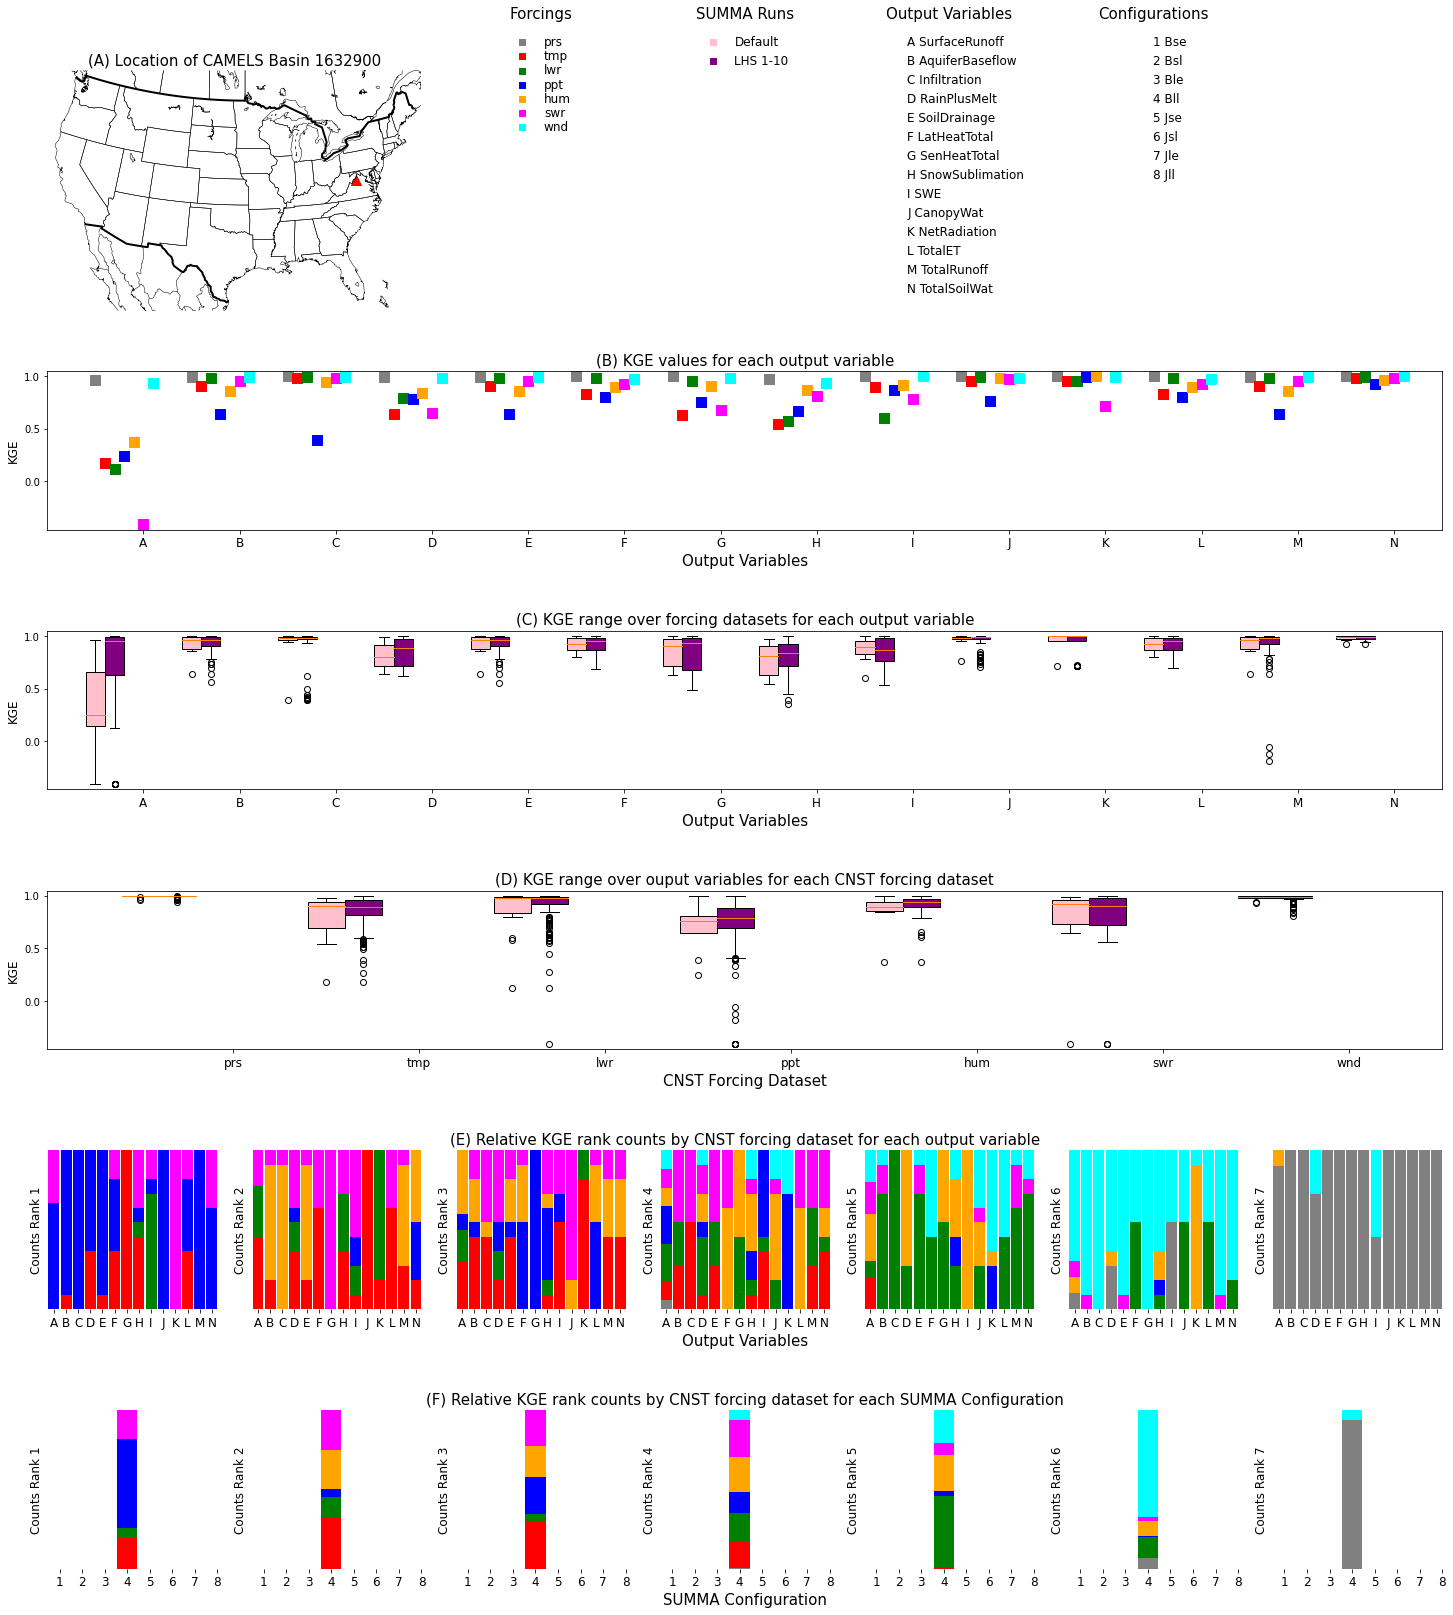

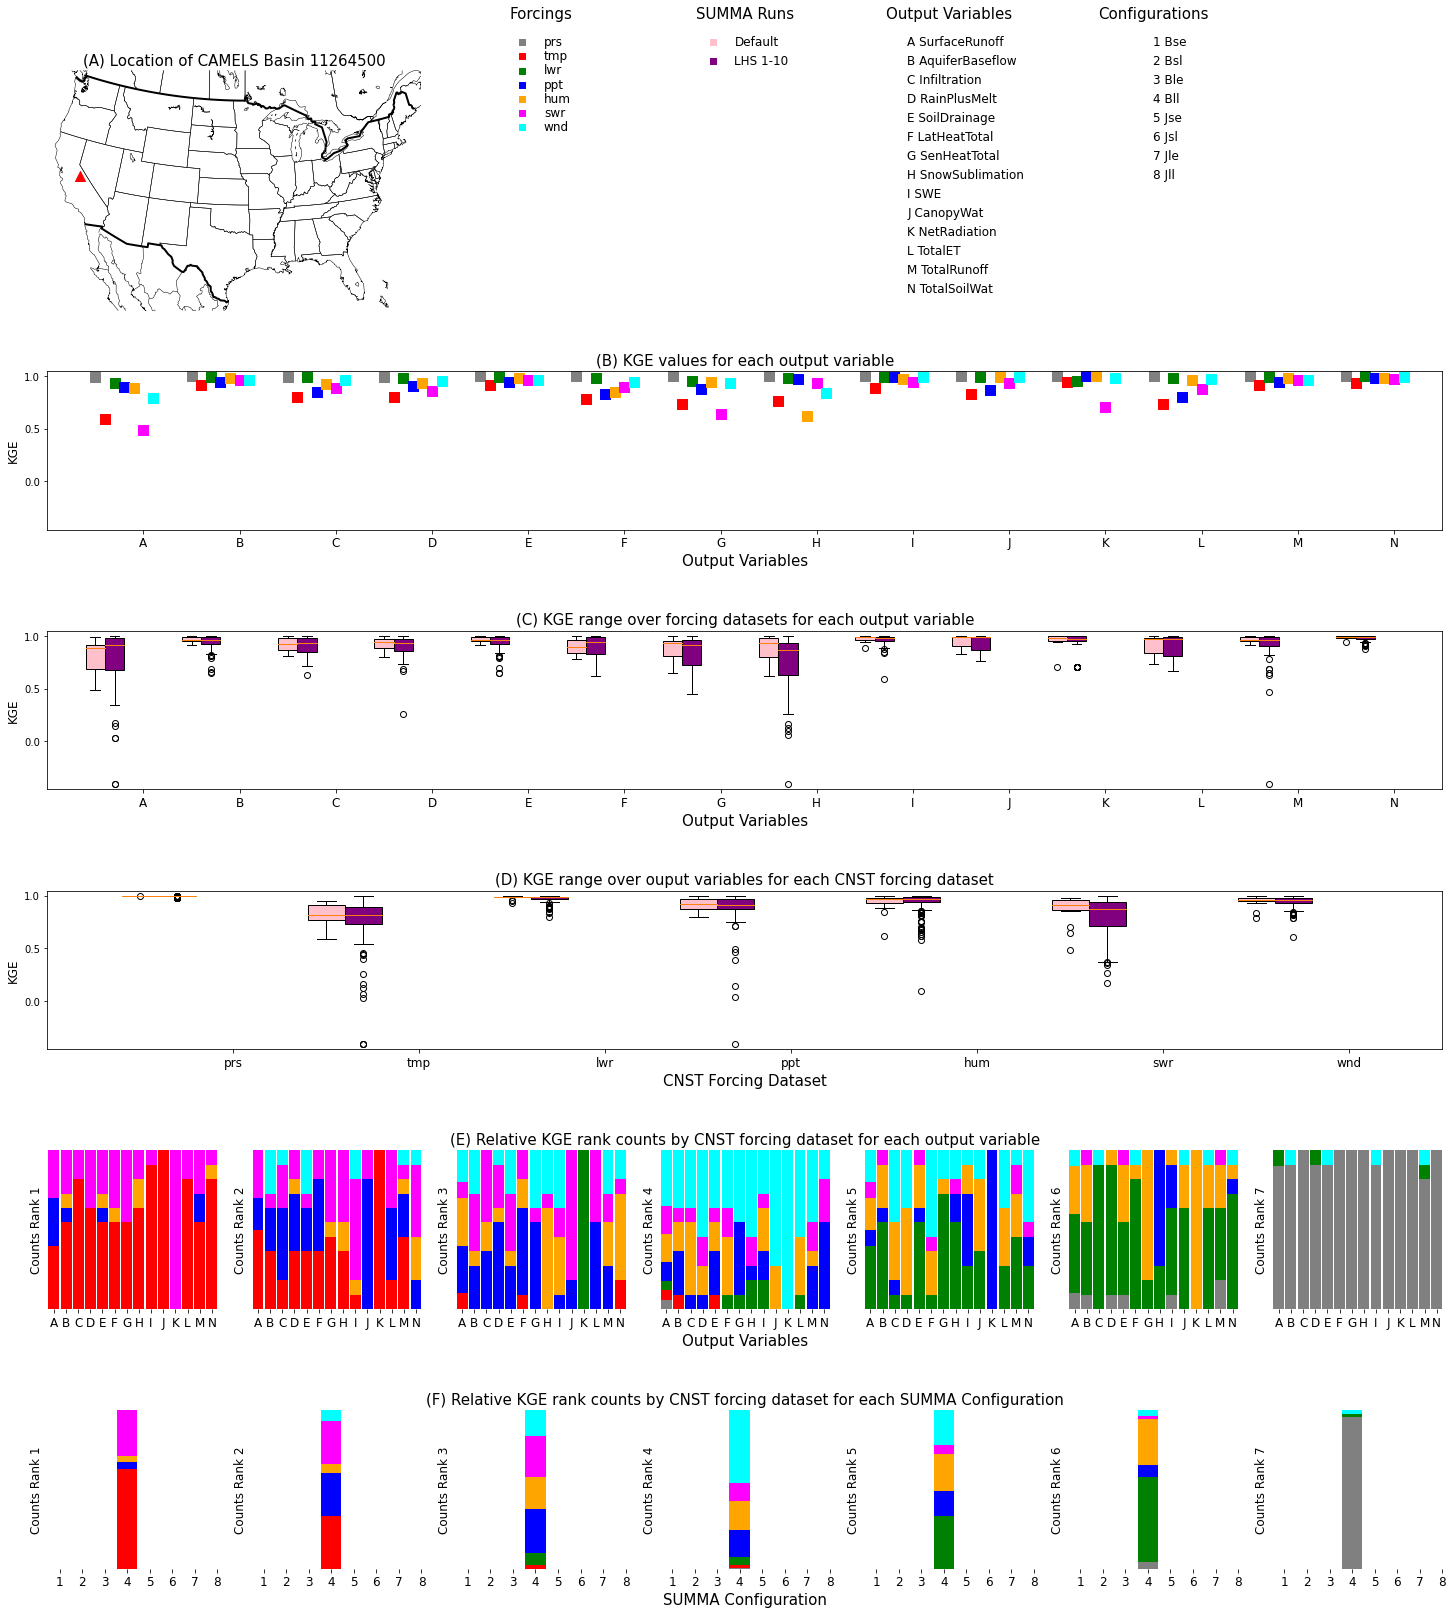

In [22]:
for h in the_hru:

    fig = plt.figure(figsize=(25, 30))

    # ------- Draw map (Plot A) ------- #
    sub1 = plt.subplot2grid((19,7), (0,0), colspan = 2, rowspan = 4)    # placing on grid

    lat=lr_attrib['gauge_lat'].sel(hru=h)
    lon=lr_attrib['gauge_lon'].sel(hru=h)
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',resolution='l',lat_1=33,lat_2=45,lon_0=-95)
    m.drawcoastlines(linewidth=0.5)
    m.drawstates(linewidth=0.5, linestyle='solid', color='k')
    m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
    x, y = m(lon, lat) 
    sub1.scatter(x,y,s=100, marker = '^', color='red') 
    plt.title('(A) Location of CAMELS Basin ' +str(h),fontsize = 15)
    sub1.axis("off")


    # ------- KGE values for each output variable (Plot B) ------- #
    sub2 = plt.subplot2grid((19,7), (4,0), colspan = 7, rowspan = 2)    # placing on grid

    for i, s in enumerate(comp_sim):
        data = rank_data[s].sel(hru = h,summary = 'total', decision = default_name)
        for j,v in enumerate(constant_vars):
            sub2.scatter(i+.1*j,data.sel(var = v),s=100, marker = 's', color=col1[j])

    plt.xlim(-0.5,len(comp_sim))
    plt.ylim(-0.46,1.05)
    plt.xticks(xtic, labels, fontsize = 12)
    plt.xlabel('Output Variables', fontsize = 15)
    plt.yticks(np.arange(0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(B) KGE values for each output variable',fontsize = 15)


    # ------- KGE range over forcing datasets (Plot C) ------- #
    sub3 = plt.subplot2grid((19,7), (7,0), colspan = 7, rowspan = 2)   # placing on grid

    for i, s in enumerate(comp_sim):
        data = rank_data[s].sel(hru = h,summary = 'total')
        for j in decision_used:
            v = decision_lab[j]
            if v=='Default': data2 = data.sel(decision = default_name)
            if v=='LHS 1-10': data2 = data.sel(decision = lat_name)
            if v=='Configuration 1-8': data2 = data.sel(decision = cfg_name)
            if v=='LHS 1-10 and Con 1-8': data2 = data.sel(decision = cfglat_name)
            bp = sub3.boxplot(xr.concat(data2, dim='var'),positions = [i+.2*j],widths=0.2,patch_artist=True)
            for patch in bp['boxes']:
                patch.set(facecolor=col2[j])  

    plt.xlim(-0.5,len(comp_sim))
    plt.ylim(-0.46,1.05)
    plt.xticks(xtic, labels, fontsize = 12)
    plt.xlabel('Output Variables', fontsize = 15)
    plt.yticks(np.arange(0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(C) KGE range over forcing datasets for each output variable',fontsize = 15)


    # ------- KGE  range over ouput variables  (Plot D) ------- #
    sub4 = plt.subplot2grid((19,7), (10,0), colspan = 7, rowspan = 2)  # placing on grid

    for i, s in enumerate(constant_vars):
        data = rank_data[comp_sim].sel(hru = h,var = s,summary = 'total')
        for j in decision_used:
            v = decision_lab[j]
            if v=='Default': data2 = data.sel(decision = default_name)
            if v=='LHS 1-10': data2 = data.sel(decision = lat_name)
            if v=='Configuration 1-8': data2 = data.sel(decision = cfg_name)
            if v=='LHS 1-10 and Con 1-8': data2 = data.sel(decision = cfglat_name)
            bp = sub4.boxplot(xr.concat(data2.to_array(), dim='decision'),positions = [i+.2*j],widths=0.2,patch_artist=True)

            for patch in bp['boxes']:
                patch.set(facecolor=col2[j])  

    plt.xlim(-0.5,len(constant_vars))
    plt.ylim(-0.46,1.05)
    plt.xticks(ztic, constvar_lab, fontsize = 12)
    plt.xlabel('CNST Forcing Dataset', fontsize = 15)
    plt.yticks(np.arange(0, 1.01,0.5).tolist())
    plt.ylabel('KGE', fontsize = 12)
    plt.title('(D) KGE range over ouput variables for each CNST forcing dataset',fontsize = 15)


    # ------- Relative KGE rank counts for each output variable (Plot E) ------- # 

    for j in np.arange(len(constant_vars)):
        plot2 = plt.subplot2grid((19,7), (13,0+j), colspan = 1, rowspan = 2)  # placing on grid
        data = rank_data.sel(hru = h,summary='rank',decision = cfglat_name)
        data = data.where(data==j+1)/(j+1)
        if default_prob==0: data = data.sum(dim='decision')
        else: data = data.fillna(0)
        data = data/data.sum(dim='var')
        for i, s in enumerate(comp_sim):
            data0 = data[s]
            data_Master = 0
            for jj, v in enumerate(constant_vars):
                plt.bar(height = data0.sel(var = v), x = i+0.5, width = 0.9, color =col1[jj], bottom = data_Master)
                data_Master = data_Master+data0.sel(var = v)

        plt.xlim(-0.05,len(comp_sim)-0.05)
        plt.ylim(0,1)
        plt.xticks(xtic, labels, fontsize = 12)
        plt.yticks([], [])
        plt.box(False)
        plt.ylabel('Counts Rank '+str(j+1), fontsize = 12)

        if j==3: plt.title('(E) Relative KGE rank counts by CNST forcing dataset for each output variable',fontsize = 15)
        if j==3: plt.xlabel('Output Variables', fontsize = 15)


    # ------- Relative KGE rank counts for each configuration (Plot F) ------- # 

    for j in np.arange(len(constant_vars)):
        plot2 = plt.subplot2grid((19,7), (16,0+j), colspan = 1, rowspan = 2)  # placing on grid
        data = rank_data[comp_sim].sel(hru = h,summary='rank',decision = cfglat_name)
        data = data.where(data==j+1)/(j+1)
        for i, s in enumerate(cfg_name):
            if lhs_config_prob==1: data0 = data.sel(decision = [s[:-1]+str(i) for i in range(1,11)])
            elif config_prob==1: data0 = data.sel(decision = s)
            else: data0 = data
            if lhs_prob==1 or lhs_config_prob==1: data0 = data0.sum(dim='decision')
            data0 = sum(d.fillna(0) for d in data0.data_vars.values())        
            data0 = data0/data0.sum(dim='var')    
            data_Master = 0
            if config_prob or lhs_config_prob ==1: ii = i
            else: ii = 3 #default configuration only
            for jj, v in enumerate(constant_vars):
                plt.bar(height = data0.sel(var = v), x = ii+0.5, width = 0.9, color =col1[jj], bottom = data_Master)
                data_Master = data_Master+data0.sel(var = v)

        plt.xlim(-0.05,len(cfg_name)-0.05)
        plt.ylim(0,1)
        plt.xticks(ctic, labelc, fontsize = 12)
        plt.yticks([], [])
        plt.box(False)
        plt.ylabel('Counts Rank '+str(j+1), fontsize = 12)

        if j==3: plt.title('(F) Relative KGE rank counts by CNST forcing dataset for each SUMMA Configuration',fontsize = 15)
        if j==3: plt.xlabel('SUMMA Configuration', fontsize = 15)

            
    # ------- Places the Legends ------- # 
    leg1 = plt.subplot2grid((19,7), (0,2))     # Plot B legend
    for i,s in enumerate(constvar_lab): plt.scatter([],[], color = col1[i], marker = 's', label = s)
    plt.axis('off')
    plt.title('Forcings',fontsize = 15)
    plt.legend(loc = 'upper center', prop = {'size':12}, frameon = False, labelspacing = .1)

    leg2 = plt.subplot2grid((19,7), (0,3))     # Plot C and D legend
    for i,s in enumerate(decision_lab): plt.scatter([],[], color = col2[i], marker = 's', label = s)
    plt.axis('off')
    plt.title('SUMMA Runs',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    leg3 = plt.subplot2grid((19,7), (0,4))     # Plot B, C, and E legend
    for i,s in enumerate(compsim_lab): plt.scatter([],[], color = 'black', marker ='', label = labels[i]+' '+s)
    plt.axis('off')
    plt.title('Output Variables',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    leg4 = plt.subplot2grid((19,7), (0,5))     # Plot F legend
    for i,s in enumerate(cfg_lab): plt.scatter([],[], color = 'black', marker = '', label = labelc[i]+' '+s)
    plt.axis('off')
    plt.title('Configurations',fontsize = 15)
    plt.legend(loc = ('upper center'), prop = {'size':12}, frameon = False)

    
    # ------- Prints the plot ------- #
    # if you want to save as a png
    plt.savefig('basin_'+str(h)+'.png', bbox_inches = 'tight')
    plt.show()